## Imports

In [82]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle

import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

from DS_2_2024_HW2_efficient_net import EfficientNet

In [83]:
tf.keras.utils.set_random_seed(16)

## Data

In [84]:
# Height, width and number of channels
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

In [85]:
# Load data. Train & Dev datasets are stored as tfrecord objects (see https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)-
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")
    
# Process data. Train & Dev are decoded from jpeg; Test data are constructed from list.
train = train.map(parse)
dev = dev.map(parse)

with open("hw2_outofsample.pickle", 'rb') as f:
    test = pickle.load(f)
test = tf.data.Dataset.from_tensor_slices(test) # see https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Build Model

Continue by initializing EfficientNet, building the model, augmentation and training.

In [86]:
# Call constructor of EfficientNet and call your object 'base_model'. You need to specify several parameters:
# - width_coefficient, depth_coefficient: determine the scale for depth and width of the network. Reasonable to start with both equal to 1.0
# - default_resolution: resolution of an input image
# - dropout_rate: dropout rate used throughout the network
# - include_top: if True then the network will include the final classification layer and produce a prediction for 1000 classes in ImageNet classification dataset,
# if False, the network will return 'image features' (the result of the last global average pooling)
# weights: path to the file for pre-trained weights. Use 'efficientnet.h5' that you have downloaded from the Kaggle competition

# Create the EfficientNet model
base_model = EfficientNet(
    default_resolution=(224),
    width_coefficient=1.0,
    depth_coefficient=1.0,
    include_top=False,
    weights='efficientnet.h5',
    dropout_rate=0.2
)

# Summary of the model architecture
base_model.summary()

Model: "efficientnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                      

In [87]:
# Calling constuctor of EfficientNet you have constructed a tf.keras.Model object. 
# Iterate over layers of that model and set their attribute 'trainable' to False for most of them,
# (in this way you will train only some of the large number of parameters; - is it reasonable to train the first or the last layers?)
# Use method .summary() to investigate the number of trainable and non-trainable parameters
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization): #BatchNormalization layers are typically kept trainable to allow them to adapt during fine-tuning.
        layer.trainable = True
    else:
        layer.trainable = False

# We don't want to print out all the layers again, only number of (non-)trainable parameters
def custom_summary(model):
    total_params = model.count_params()
    trainable_params = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
    non_trainable_params = total_params - trainable_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

# Call the custom summary function
custom_summary(base_model)

Total parameters: 4049564
Trainable parameters: 42016
Non-trainable parameters: 4007548


In [89]:
# Use API logic seen on the practicals to build the following model:
# The input layer takes images with 3 channels and passes them to the initialized EfficientNet model
# After processing through Efficient model, add few more fully connected layers, with regularization of your choice
# Output of your model should be a vector of probabilities for each of the breed.

inputs = tf.keras.layers.Input([H, W, C])
hidden = base_model(inputs)[0]
dense = tf.keras.layers.Dense(32, activation = tf.nn.relu)(hidden)
outputs = tf.keras.layers.Dense(34, activation = tf.nn.softmax)(dense)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense_8 (Dense)             (None, 32)                40992     
                                                                 
 dense_9 (Dense)             (None, 34)                1122      
                                                           

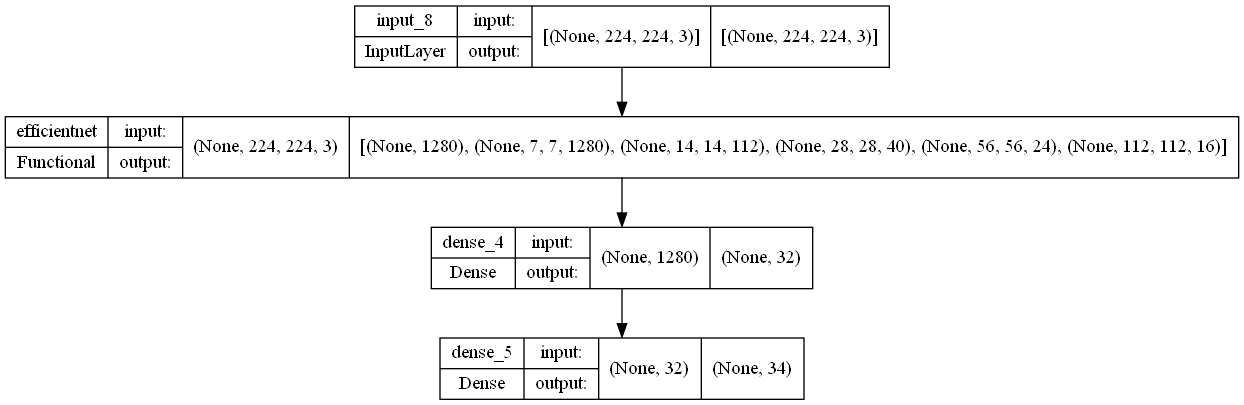

In [52]:
#Extra ze cvičení

# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [90]:
# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())


#Note - doporučuje smoothing po augment train?

In [ ]:
def label_smooth_train(image, labels, alpha, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    labels *= (1 - alpha)
    labels += alpha / n_labels
    return image, labels

def label_smooth_dev(image, labels, n_labels):
    labels = tf.one_hot(tf.cast(labels, tf.int32), n_labels)
    labels = tf.cast(labels, tf.float32)
    return image, labels

In [91]:
# We define pipeline that will consist of augmentation and batching

def augment_train(input):
    image = input['image']
    label = input['label']
    # Augmentation procedures (modify to your wish)

    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    #image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])

    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    # Augmentation procedures (add to your wish)
    # Note: if we add augmentation also to dev dataset, we can assume that
    # performance of test dataset will be better as test dataset is not augmented
    
    return image, label


In [92]:

# Now we apply augmentation using .map()
train = train.map(augment_train)
validation= dev.map(augment_dev)

batch_size = 32 
# Apply .batch() to 'train' and 'dev' with some choice of batch size
train = train.batch(batch_size)
validation = validation.batch(batch_size)

In [55]:
#OLD

class CAGS:
    H = 224  # example height
    W = 224  # example width
    C = 3    # example number of channels

def augment_train(image, label, smooth_alpha, n_labels):
    # Augmentation procedures (modify to your wish)
    image = tf.image.random_jpeg_quality(image, 80, 100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, [CAGS.H, CAGS.W, CAGS.C])
    
    # Label smoothing
    label = label * (1.0 - smooth_alpha) + smooth_alpha / n_labels
    
    return image, label

def augment_dev(image, label):
    # Augmentation procedures (add to your wish)
    return image, label

# Create batches with label smoothing
batch_size = 128
smooth_alpha = 0.05
n_labels = 10


train_ds = train.take(train_size)
rest = train.skip(train_size)
validation_ds = dev.take(valid_size)
# Now we apply augmentation using .map()
# Now we apply augmentation using .map()
train_ds = train.map(lambda x, y: augment_train(x, y, smooth_alpha, n_labels))
validation_ds = dev.map(lambda x, y: augment_dev(x, y))

# Apply .batch() to 'train' and 'dev' with some choice of batch size
train = train_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

NameError: name 'train_size' is not defined

In [93]:
# Fit your model using early stopping

epochs = 2

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/train')

model.fit(train,
          epochs=epochs,
          validation_data=validation,
          callbacks=[early_call])

Epoch 1/2
     67/Unknown - 396s 6s/step - loss: 3.2481 - sparse_categorical_accuracy: 0.1937WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
67/67 [==============================] - 409s 6s/step - loss: 3.2481 - sparse_categorical_accuracy: 0.1937 - val_loss: 2.3666 - val_sparse_categorical_accuracy: 0.5686
Epoch 2/2
67/67 [==============================] - 393s 6s/step - loss: 1.9779 - sparse_categorical_accuracy: 0.5770 - val_loss: 0.9206 - val_sparse_categorical_accuracy: 0.7941


# Evaluate

Load test dataset, predict labels and store results. Note that (for educational purposes) we load the data from pickled list. Therefore, transformation to Tensorflow dataset has to be done.

In [96]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)

# Apply batching also to 'test'
#test = test.batch(batch_size)
batch_size = 32 
test = test.batch(batch_size)
# Predict
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

# Store results
pd.DataFrame({'prediction': test_prediction}).to_csv('data/hw2_outofsample_prediction.csv', index=True, header=True)